## MeltModel.ipynb, Kennicott Glacier melt calculator
### Mike Loso, Updated 2/4/2022

## Prep temp data
This code loads up histograms of the Kennicott Glacier (based off of the 2012 IFSAR and a 2012/2013 outline). There are three histograms: one full histogram, one of debris-covered ice, and one of clean ice. This code uses the latter two to calculate melt in each 10m bin. 

The temperature rule is: 
#### ON DEBRIS
{temp at elev *x*} = ( {temp at Gates AWS} * 0.571476 + 1.775760 ) - ( 4.86 * ( *x* - 1070) * 0.001 )

#### OFF DEBRIS
{temp at elev *x*} = ( {temp at Gates AWS} * 0.571476 + 1.775760 ) - ( 3.72 * ( *x* - 1070) * 0.001 )

The histograms count numbers of 5m x 5m pixels in each of 456 bins that separate pixels into 10m elevation bands. So area in each elevation band is "heights" * 25 m. Histogram columns are {'binedgeR', 'binedgeL', 'bincenters', and 'heights'}.

Temperature data come from Gates AWS without any modifications.

## Load ablation stake data and calculate melt models
Then this code loads up ablation data from NPS stakes. See notes below. 



In [2]:
## IMPORT PACKAGES

# standard
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
import datetime
import os, csv

# specialized
from scipy import stats
from matplotlib import cm
# statsmodels is a nice tool for regressions
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import pickle
import numpy.ma as ma

# set default figure size
figsize=(10,6)

In [3]:
## LOAD GATES AWS (NPS LONG TERM) RECORD AND RESAMPLE/CLEAN UP

# First load Gates long-term AWS record
# set working directory
data_dir = r'~/MLo/KennGlac/data/Raw_Climate_Records/current 2021/GATES hrly all vars 2016_01_01 to 2021_11_10/from telemetry/'
# Load an excel workbook that is in the local directory
csv=os.path.join(data_dir,'GGLA2.2021-11-10.csv')
# Load the first worksheet as 'wb', treat -9999 as nan|, make first column (dates) the index
nps=pd.read_csv(csv,skiprows=[11],na_values=[-9999],header=10,parse_dates=['Date_Time'],usecols=['Date_Time','air_temp_set_1'])
# convert zulu time to AK Time
nps.loc[:,'AKdate'] = nps['Date_Time'].dt.tz_convert('US/Alaska')
# shift timestamp 33 minutes to read on the hour
nps.AKdate = nps.AKdate - pd.Timedelta(33,'minutes') # on the hour
# keep time as it is but remove time zone info (stays local AK)
nps.loc[:,'AKdate'] = nps.AKdate.dt.tz_localize(tz=None)
nps=nps.set_index(['AKdate'])
# clean up
del nps['Date_Time']
nps.rename(columns={'air_temp_set_1':'GatesNPS'},inplace=True)

# print(nps.head(2))

In [4]:
## LOAD BINNED ELEVATION DATA PICKLED FROM KENNRIVQ.IPYNB

# load pickled elevation data in bins (clean and debris)
# set working directory
data_dir = r'~/MLo/KennGlac/data'
# load data as two pandas dataframes: debris and pickle
debris = pd.read_pickle(os.path.join(data_dir, 'debrisbins.pickle'))
clean = pd.read_pickle(os.path.join(data_dir, 'cleanbins.pickle'))

In [5]:
## CREATE 2-d ARRAY OF TEMPS, WITH DATETIME (in rows) and ELEVATIONBIN (in columns)
## Ultimately 2 arrays: one for clean and one for debris.

# There should be 50,567 rows (datetimes) IF we do hourly. (dates and temps available in nps.AKdate and nps.GatesNPS)
# There should be 456 columns (bincenters). (bincenters available in clean.bincenters or debris.bincenters)

# pre-create empty arrays (one for debris one for clean) to populate
number_of_rows = 50567
number_of_columns = 456
cleantemps=np.zeros((number_of_rows,number_of_columns))
# and for dirty ice
debristemps=np.zeros((number_of_rows,number_of_columns))

# change bincenters to np.array 'centers' and 'datesf' for numpy work
centers=debris['bincenters'].to_numpy()
# change Gates temp record to np.array 'gatestemps'. single brackets make it 1d array, not a 2d array with 50567 rows and 1 column
gatestemps=nps['GatesNPS'].to_numpy()
# change Gates index to numpy array of datetimes (note these won't work for plotting surface below, so will change back to float there)
dates=nps.index.to_numpy(dtype='datetime64[ns]')

# create loop to populate arrays (might be a better way to do this). Iterate over columns (bincenters)
# gatestemp is a column array of temperatures over record
# debristemps[:,i] is the index for the column with the particular bincenter elevation we're working with
# starting column index
col=0
for i in centers:
    # calculate air temp on dirty ice for each timestep as function of Gates temp and elevation
    debristemps[:,col]=((gatestemps)*0.571476 + 1.775760)-(4.86*(i-1070)*.001);
    # calculate air temp for each clean ice bin as function of Gates temp
    cleantemps[:,col]=((gatestemps)*0.571476+1.775760)-(3.72*(i-1070)*.001);
    col=col+1

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
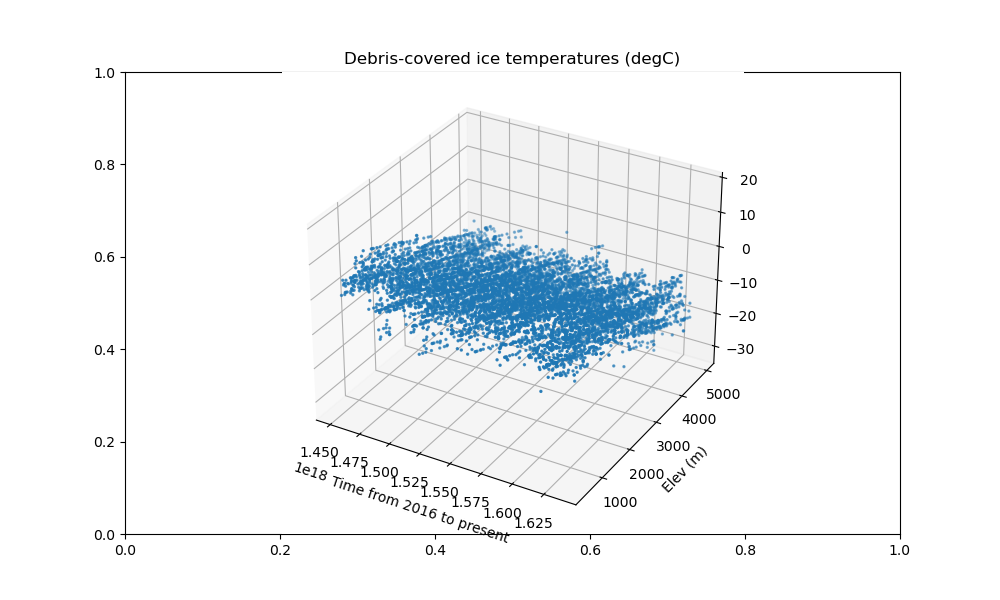

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
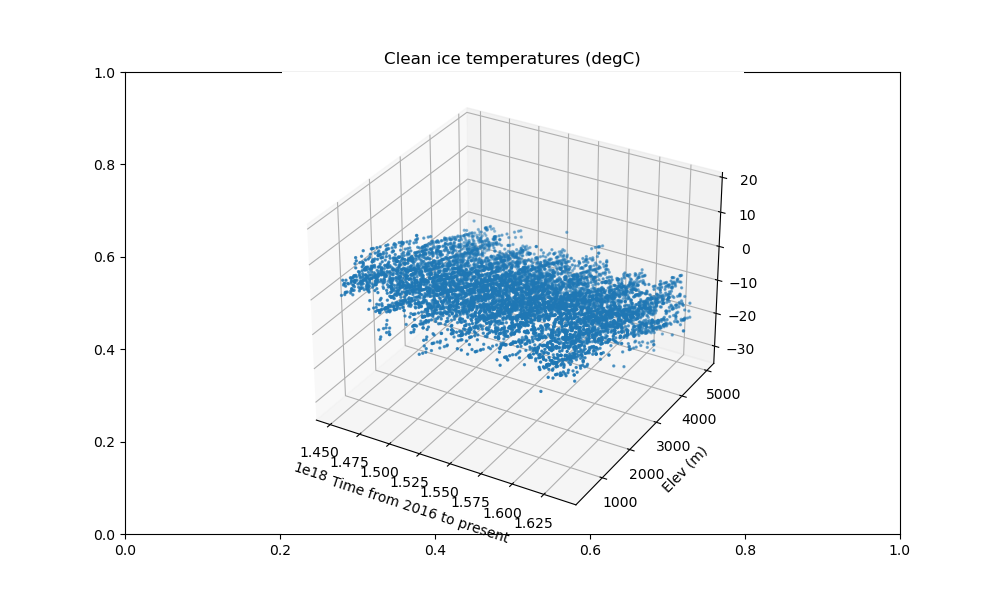

In [6]:
### PLOT 2-d ARRAYS OF TEMP VS DATE AND ELEVATION
              

# Turn dates (dtype=datetime64) into float for purposes of plotting. Call it datesf
datesf=nps.index.to_numpy(dtype='float')

# For some reason plot_surface requires the x and y axes to be 2d, so expand each to be same shape as data, using meshgrid
X, Y = np.meshgrid(datesf,centers)  # `plot_surface` expects `x` and `y` data to be 2D

# cleantemps and debristemps are each 50567x456, but have a small fraction (<1%) nans, 7752 to be exact. Turn into zeros.
cleantemps_mask=np.isfinite(cleantemps)
debristemps_mask=np.isfinite(debristemps)
cleanmasked=np.ma.array(cleantemps,mask=np.column_stack((cleantemps_mask)))
debrismasked=np.ma.array(debristemps,mask=np.column_stack((debristemps_mask)))

## FIGURE 1
fig1=plt.subplots(figsize=(10,6))
# This next line is key for creating 3d surface plot
ax=plt.axes(projection='3d')

# Don't know what the '.T' suffix is needed for, but seems to work
ax.scatter(X.T,Y.T,debrismasked,s=2,depthshade=True)
plt.xlabel('Time from 2016 to present')
plt.ylabel('Elev (m)')
plt.title('Clean ice temperatures (degC)')

## FIGURE 2
fig2=plt.subplots(figsize=(10,6))
# This next line is key for creating 3d surface plot
ax=plt.axes(projection='3d')

# Don't know what the '.T' suffix is needed for, but seems to work
ax.scatter(X.T,Y.T,debrismasked,s=2,depthshade=True)
plt.xlabel('Time from 2016 to present')
plt.ylabel('Elev (m)')
plt.title('Debris-covered ice temperatures (degC)')
                  
plt.show()

(50567, 456)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
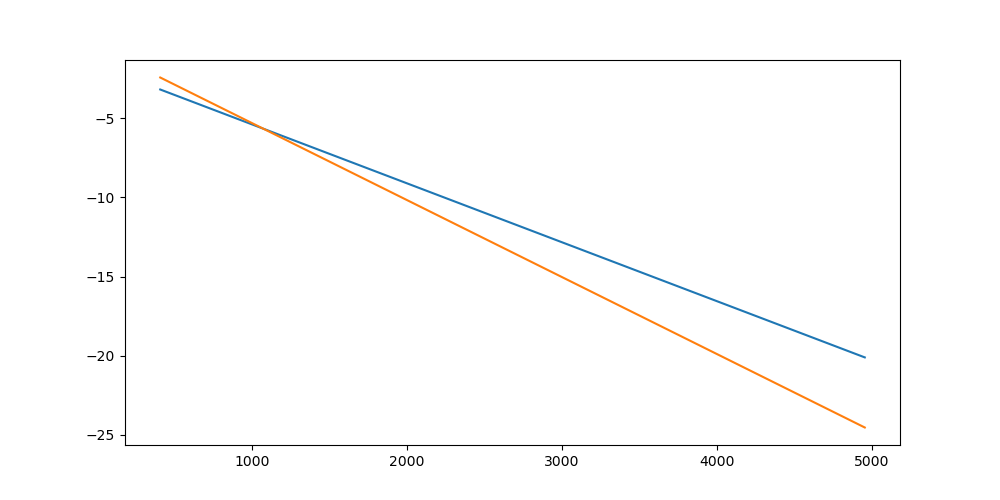

['2016-01-01T03:00:00.000000000' '2016-01-01T04:00:00.000000000'
 '2016-01-01T05:00:00.000000000' ... '2021-11-09T23:00:00.000000000'
 '2021-11-10T00:00:00.000000000' '2021-11-10T01:00:00.000000000']


In [7]:
## PLOT A TIMESLICE OF TEMPERATURES AT ALL ELEVATIONS FOR DEBRIS AND NON-DEBRIS

print(cleantemps.shape)

fig,ax=plt.subplots(figsize=(10,5))
plt.plot(centers,cleantemps[8900,:])
plt.plot(centers,debristemps[8900,:])
plt.show()
print(dates)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
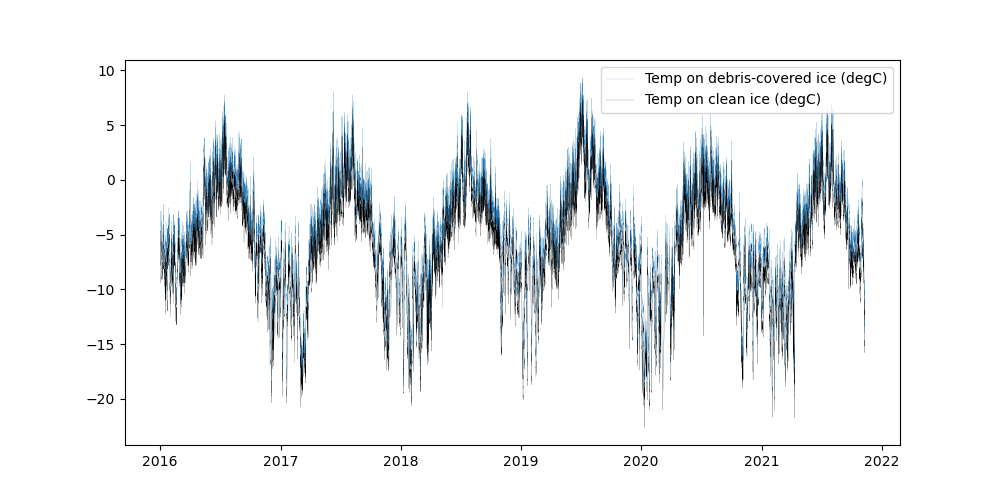

In [8]:
## PLOT A SLICE OF TEMPERATURES AT ALL TIMES FOR ONE TIME FOR DEBRIS AND NON-DEBRIS


fig,ax=plt.subplots(figsize=(10,5))
plt.plot(dates,cleantemps[:,225],linewidth=.1)
plt.plot(dates,debristemps[:,225],'k',linewidth=.1)
plt.legend({'Temp on clean ice (degC)','Temp on debris-covered ice (degC)'})
plt.show()

### Next step, import ablation records from NPS stakes
Next I import a record of measured ablation totals from Kennicott Glacier (KennSummerAblation.xlsx). These were exported from the SQL Glaciers database using a saved query. It is expored with the columns 'Site', 'Date_Time', 'Latitude', 'Longitude', 'HAMSL_m', 'Melt_Season_SWE_Change_m', 'LastVisitDate', 'DaysSinceLastVisit'. I manually added 'IceSnow', which describes the surface that was melting at the beginning/end of the melt season, respectively, and also 'Summ_Accum', which could have been part of the query but I didn't think of it. Note that melt season change ignores summer accum (reflects the surface under the summer accum), and the summ_accum--when it shows up, stops the melt season (if it persists).

Also, there is one duplicate record that comes out of the SQL server export as of 12/4/2021: two versions of Kenn6100 in 2019. The one with a melt season change of -2.805 is preferred, so I manually removed a record with change of -2.746. I also separated out 3 records from Gates 7200 that have such small melt responses that I think they skew the DDF calculation, likely because they received significant mid-summer precip. I called them "snow/snow/suspect" in the IceSnow category. This could be fixed in db query somehow in the future.

In [9]:
## LOAD DATA
# set working directory
data_dir = r'~/MLo/KennGlac/data'
# Load an excel workbook that is in the local directory
xlsx=pd.ExcelFile(os.path.join(data_dir,'KennSummerAblation.xlsx'))
# Load the first worksheet, treat -9999 as nan, make second column index (DateTime) 
wb=pd.read_excel(xlsx,sheet_name='Sheet1',na_values=[-9999],index_col=1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
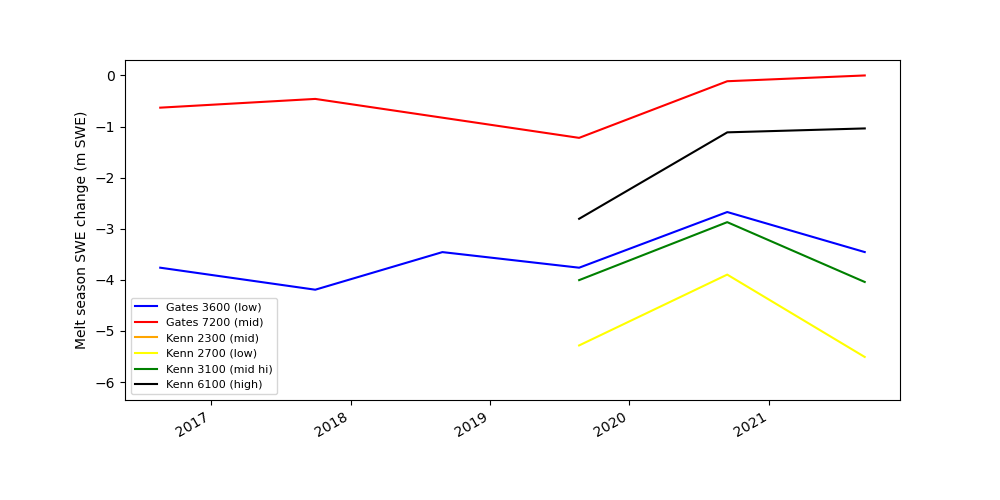

In [10]:
## VIEW RAW DATA

# # Print summary of worksheet ('wb')
# print(wb.head())
# # Print datatypes (dtypes) of DataFrame (wb)
# print(wb.dtypes)

# Plot with each site its own color
# create array of colors and start count at 0
colors=['blue','red','orange','yellow','green','black']
colorkey=0

fig, ax=plt.subplots(figsize=(10,5))

# group entries by site, then for each group
grouped = wb.groupby('Site')

# loop through each group
# key is the ordered list of sites (the grouping variable)
# group is the ordered list of rows in each group
# use_index forces 'plot' to use the index (Date_Time) as the x axis
for key, group in grouped:
    group.plot(ax=ax, kind='line', use_index=True, y='Melt_Season_SWE_Change_m', label=key, color=colors[colorkey])
# increment the colorkey
    colorkey=colorkey+1
    ax.legend(loc='lower left',fontsize=8)
    plt.xlabel('')
    plt.ylabel('Melt season SWE change (m SWE)')
plt.show()


In [11]:
## EXTRACT TEMPERATURE HISTORY THAT MATCHES EACH STAKE RECORD SO I CAN COMPUTE DD FOR EACH OBSERVATION

# Note that all stakes are on clean ice so we'll use the 'cleantemps' record

# Create new row and find index for index of correct binned elevation. wb.centersloc
wb=wb.assign(centersloc='')
# make into numpy
stakecenters=wb['HAMSL_m'].to_numpy()
# this finds the indices of values in centers that are just ABOVE values of stake elevations
q=centers.searchsorted(stakecenters)
# this finds out how far apart the stakes and the bincenters are. 
diff=centers[q]-stakecenters
# where it is greater than 5, we should decrease the index by 1, placing them in the right bin
q[diff>5]=q[diff>5]-1
# assign to table
wb.centersloc=q

# Create new row and find index for starting date indices in wb
wb=wb.assign(datestartloc='')
# Create new row and find index for ending date indices in wb
wb=wb.assign(dateendloc='')
# make into numpy
art=wb['LastVisitDate'].to_numpy()
nd=wb.index.to_numpy()
# artindex+1 are the indices of the values in dates that are just below (AFTER) the first dates of stake measurements
artindex=dates.searchsorted(art)+1
# ndindex are the indices of the values in dates are are just above (before) the final dates of stake measurements
ndindex=dates.searchsorted(nd)
# assign to table
wb.datestartloc=artindex
wb.dateendloc=ndindex

# Create new row for DD in wb
wb=wb.assign(DD='')
# loop through to get DD
for i in range(0,21):
    # create temp vector of appropriate temps
    hourlytemps=cleantemps[[range(wb.datestartloc[i],wb.dateendloc[i])],[wb.centersloc[i]]]
    # there are a TOTAL of 17 hours in the entire record used here that are NaNs. Never more than one in a single interval
    # So just turn all NaNs into zeros. Very trivial effect on record. 
    np.nan_to_num(hourlytemps,copy=False)
    # find and turn all zero values into 0
    hourlytemps[hourlytemps<0]=0
    # calculate degree days
    dd=np.sum(hourlytemps*(1/24))
    # assign dd to table
    wb.DD[i]=dd
    
# This code generates a pandas warning I should fix. But it works.

/tmp/ipykernel_412/3098734025.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wb.DD[i]=dd


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
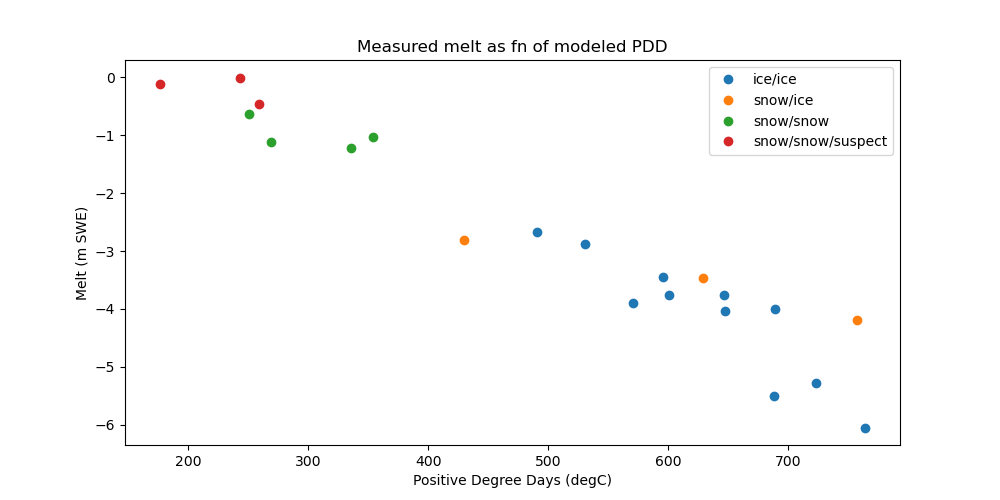

In [12]:
## COMPARE DD TO MELT

fig, ax=plt.subplots(figsize=(10,5))

# group entries by ice or snow
groups = wb.groupby('IceSnow')

# loop through each group
# name is the ordered list of IceSnow types (the grouping variable)
# group is the ordered list of rows in each group
for name, group in groups:
    ax.plot(group.DD, group.Melt_Season_SWE_Change_m, marker='o', linestyle='', label=name)

plt.title('Measured melt as fn of modeled PDD')
plt.ylabel('Melt (m SWE)')
plt.xlabel('Positive Degree Days (degC)')
plt.legend()

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
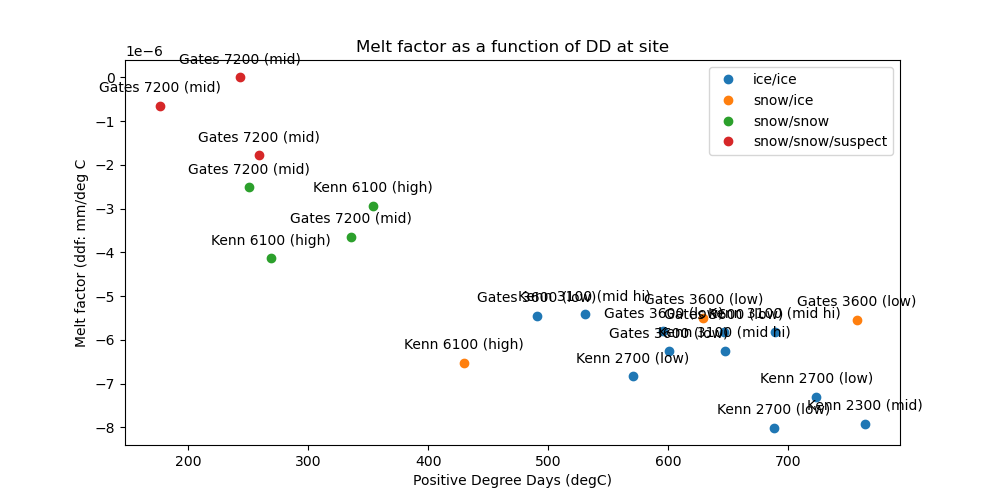

In [13]:
## CALCULATE DEGREE DAY FACTOR

# Should be in units (mm w.e. / deg C), typically ksub s (snow) or ksub i (ice)

# convert melt and PDD to numpy arrays
melt=wb['Melt_Season_SWE_Change_m'].to_numpy()
# get melt in terms of mm
meltmm=melt*1000
PDD=wb['DD'].to_numpy() 

fig, ax=plt.subplots(figsize=(10,5))

# create new variable, ddf, in wb. This is the degree day factor for each site at each year
wb['ddf']=(wb.Melt_Season_SWE_Change_m/1000)/(wb.DD)

# group entries by ice or snow
groups = wb.groupby('IceSnow')

# loop through each group
# name is the ordered list of IceSnow types (the grouping variable)
# group is the ordered list of rows in each group
for name, group in groups:
    ax.plot(group.DD, group.ddf, marker='o', linestyle='', label=name)

plt.title('Melt factor as a function of DD at site')
plt.ylabel('Melt factor (ddf: mm/deg C')
plt.xlabel('Positive Degree Days (degC)')
plt.legend()

# label points
# font1={'family':'serif','color':'darkred','weight':'normal','size':6}
ssite=wb['Site'].to_numpy()
ddf=wb['ddf'].to_numpy()
label=f'({ssite})'
for x,y,l in zip(PDD,ddf,ssite):
    plt.annotate(l,(x,y),textcoords='offset points',xytext=(0,10),ha='center')
plt.show()

### SUMMARY

Degree Day Factors look pretty reasonable. About -5 to -8 mm/degC for ice, more variable -4 to 0 for snow. For ice they look pretty good, except they seem to be a little systematically low at Kenn 2700 and Kenn 2300. Could be my temp relationship doesn't have a big enough lapse rate, but also possible it's because they're anomalously close to moraines or just a little dirty. I think either is possible but we don't have good data to prove either, so we'll just leave them. For ice and snow they are more mixed up, but those are all sites that can potentially receive midsummer snow, especially at Gates 7200, where it isn't necessarily recorded as summer accumulation. In those cases we would find an anomalously low DDF, and I think especially those two with values >-1 that's the case.

So, we'll do a regression of all ice sites to get pdd/ice, and we'll exclude the snow/ice completely, and for snow only we'll use all but the two >-1.

In [14]:
## Do regressions to get DDFs for ICE

# create melt in mm column in wb
wb['meltmm']=wb.Melt_Season_SWE_Change_m * 1000

# ice only, meltice as a function of DD
meltice = np.asarray(wb.meltmm.loc[wb.IceSnow=='ice/ice'])
pddice = np.asarray(wb.DD.loc[wb.IceSnow=='ice/ice'])

model=sm.OLS(meltice.astype(float),pddice.astype(float)).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              510.8
Date:                Thu, 10 Feb 2022   Prob (F-statistic):                    6.47e-10
Time:                        12:56:12   Log-Likelihood:                         -85.751
No. Observations:                  11   AIC:                                      173.5
Df Residuals:                      10   BIC:                                      173.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/mycloso/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [15]:
## Do regressions to get DDFs for SNOW (this EXCLUDES suspect points at Gates 7200)

# create melt in mm column in wb (already done above)
# wb['meltmm']=wb.Melt_Season_SWE_Change_m * 1000

# snow only, meltsnow as a function of DD
meltsnow = np.asarray(wb.meltmm.loc[wb.IceSnow=='snow/snow'])
pddsnow = np.asarray(wb.DD.loc[wb.IceSnow=='snow/snow'])

model=sm.OLS(meltsnow.astype(float),pddsnow.astype(float)).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              102.5
Date:                Thu, 10 Feb 2022   Prob (F-statistic):                     0.00205
Time:                        12:56:14   Log-Likelihood:                         -26.288
No. Observations:                   4   AIC:                                      54.58
Df Residuals:                       3   BIC:                                      53.96
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/mycloso/miniconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


### DDFs

#### **Snow (with all snow/snow sites--code not shown)**
DDF for snow is -2.5913 mm/PDD with R2 of 0.803 and F-statistic of 24.51. p<<.05. n=7

#### **Snow (with snow/snow sites excluding suspect msmnts at Gates 7200)**
DDF for snow is -3.3115 mm/PDD with R2 of 0.972 and F-statistic of 102.5. p<<.05. n=4

#### **Ice**
DDF for ice is -6.60 mm/PDD with R2 of 0.98 and F-statistic of 510.8. p<<.05. n=11

next steps: plot DDF plots for presentation

plot march-november temp histories at each site, compare with measurement interval
calculate pre and post-measurement melt at each site
plot pre and post along with actual and modeled (mid-summer) at a few sites
calculate full-season melt at all sites based on binning

In [16]:
## SAVE DATA FROM THIS NOTEBOOK SO I CAN START A NEW ONE

## SAVE GatesNPS (temps at Gates)

# rename nps dataset (this is the full record of hourly temps at Gates long-term RAWS)
# index is 'AKdate' and temps column is 'GatesNPS'
GatesNPS = nps

## save data to pickle
# set working directory
data_dir = r'~/MLo/KennGlac/data'

# set pickle path (data_dir is directory, nps.pickle is dataset)
GatesNPS_path = os.path.join(data_dir,'GatesNPS.pickle')

# save variable dataframes
GatesNPS.to_pickle(GatesNPS_path)


## SAVE ablation (ablation stake data)

# rename nps dataset (this is the full record of hourly temps at Gates long-term RAWS)
# index is 'DateTime' and there are many columns
ablation = wb

## save data to pickle
# set working directory
data_dir = r'~/MLo/KennGlac/data'

# set pickle path (data_dir is directory, homogenized_hobos.pickle is dataset)
ablation_path = os.path.join(data_dir,'ablation.pickle')

# save variable dataframes
ablation.to_pickle(ablation_path)


## also should SAVE cleantemps and debristemps and centers and dates


In [17]:
## SIMPLE EXERCISE
## USE DD MODELS WITHOUT STAKE DATA EXPLICITLY TO CALCULATE GLACIER-WIDE MELT ON ICE ONLY

## LOAD BINNED RASTER DATA

# fullbins, debrisbins, and cleanbins are are panda dataframes
# data are numbers of 5m x 5m pixels in each of 456 bins that separate pixels into 10m elevation bands. 
# So area in each elevation band is "heights" * 25 m.

# set working directory
data_dir = r'~/MLo/KennGlac/data'
fullbins = pd.read_pickle(os.path.join(data_dir, 'fullbins.pickle'))
cleanbins = pd.read_pickle(os.path.join(data_dir, 'cleanbins.pickle'))
debrisbins = pd.read_pickle(os.path.join(data_dir, 'debrisbins.pickle'))

# zero out all negative temperatures
cleantemps[cleantemps<0]=0
debristemps[debristemps<0]=0
# remove nans
np.nan_to_num(cleantemps,copy=False)
np.nan_to_num(debristemps,copy=False)

# create 4 new matrices to describe hourly melt as a function of time (dates) and elevation (centers).
# four matrices will calculate for 2x2 matrix of debris/clean and snow/ice
# base data are cleantemps and debristemps, plus ddf's
# remember these ddfs (ddfice24 and ddfsnow24) are for a full day. Must divide by 24 to get hourly melt
ddfice24=-6.60
ddfsnow24=-3.31
# values below are hourly melt
ddfice = ddfice24/24
ddfsnow = ddfsnow24/24

# The four matrices below are DDF-based melt rates, IN MM/HR, of all dates and elevations on glacier
cleansnowmelt=cleantemps*ddfsnow
cleanicemelt=cleantemps*ddfice
debrissnowmelt=debristemps*ddfsnow  # note that the debris-based temps wouldn't strictly speaking change during snowcover, but doesn't matter much
debrisicemelt=debristemps*ddfice  # only this one would change if I had cameron's data

# First try, just use cleanicemelt and debrisicemelt and don't worry about snow. See what I get.

# extract heights from binned raster data and transpose so they are in a single row
# double brackets make it 2d arraywith 456 rows and 1 column
cleanheights=cleanbins[['heights']].to_numpy()
debrisheights=debrisbins[['heights']].to_numpy()
# multiply by 25 meters and transpose them to make them row vectors, not columns, of binned glacier area in square meters
cleanarea=(cleanheights*25).T
debrisarea=(debrisheights*25).T
print(debrisarea.shape)
# multiply melt times heights (and divide by 1000 to convert mm to m) to get matrix of actual volumetric hourly melt (m^3) in each debris band
cleanicemeltbinned=cleanicemelt*cleanarea/1000
cleansnowmeltbinned=cleansnowmelt*cleanarea/1000
debrisicemeltbinned=debrisicemelt*debrisarea/1000
debrissnowmeltbinned=debrissnowmelt*debrisarea/1000

# get sums across columns to get total hourly glacier melt (all elevations combined) for any given hour
hrcleanice=cleanicemeltbinned.sum(axis=1)
hrcleansnow=cleansnowmeltbinned.sum(axis=1)
hrdebrisice=debrisicemeltbinned.sum(axis=1)
hrdebrissnow=debrissnowmeltbinned.sum(axis=1)
totalicemelt=np.sum(hrcleanice)+np.sum(hrdebrisice)

# RIGHT NOW JUST CALCULATING AS IF ENTIRE GLACIER WERE ICE: cum melt = -8599.94 km3

(1, 456)


In [33]:
###### ALTERNATE WAY OF CALCULATING DEBRIS-ICE-MELT, USING CAMERON AND ROUNCE DATA

##### CAREFUL!!! SUPER LONG RUN TIME FOR THIS CELL!!

# If you use this, comment out the debrisicemelt... line above
# Here is the form we need to use, instead of y=-6.60. y=6.4669*np.exp(-.08150151*x). 

# This cell uses a raster of DDFs generated in arcmap by multiplying the rounce debris thickness map times DDF
# where DDF=a*e^(-cx)+d where a is 5.93712, c is -0.10651, and d is 1.06660, which you can code as y=5.93712*np.exp(-0.10651*x)+1.06660.  
# NOTE THAT X IS units CM. So in raster calculator you have to muliply x (thickness) * 100

# get thickness tif 
# set working directory
data_dir = r'~/MLo/KennGlac/data'
# Define relative path to file (this is different: DDFactors pre-calculated on a per-pixel basis)
dem_path_rounceDDF = os.path.join(data_dir,
                            r"2013_rouncethick_DDFtry10.tif")
# get elev tif
# Define relative path to file (this is the debris-only dem)
dem_path_debris = os.path.join(data_dir,
                            "2013_debris_clip_elev.tif")

## TURN INTO ARRAYS
# Open tif images and save as numpy arrays (im_elev_ar and im_DDF_ar)
im_DDF=Image.open(dem_path_rounceDDF)
im_DDF_ar=np.array(im_DDF)
im_elev=Image.open(dem_path_debris)
im_elev_ar=np.array(im_elev)

# turn missing values-3.402823e+38 into 10,000 in DEM (always too cold to melt)
im_elev_ar[im_elev_ar<-100]=10000
# turn missing values in DDF into zeros (no data, no melt possible)
im_DDF_ar[im_DDF_ar<0]=0

# resample at daily interval to save time (npsdaily)
npsdaily=nps.resample(rule='24H', offset=0).mean()

# then save new dates vector and temps vector
gatestempsD = npsdaily['GatesNPS'].to_numpy()
datesD = npsdaily.index.to_numpy(dtype='datetime64[ns]')

# pre-create a vector for saving melt at each timestep
debrismeltcum = np.zeros(shape=[len(datesD),1])

for i in range(len(datesD)):
    # uncomment line below if you wantt to track progress
    # print(i)
    # calculate temps for that hoursteps for each pixel in those dems, at each time step t (from dates, 50567)
    # where gatestemp is 50567 temp record and z is elevation of pixel
    tempT = ((gatestempsD[i] * 0.571476) + 1.775760) - (0.00486 * (im_elev_ar - 1070))
    # remove all negative temps
    tempT[tempT<0]=0
    # then for each pixel in those dems, at same time steps, calculate melt (in m SWE per 25m pixel per day) (*25 / 1000)
    meltT = tempT * im_DDF_ar * 0.025
    # now you have meltT, for one hour timestep, a raster of melt in m SWE per 25m pixel. 
    # need to bin or save it if you want to plot it, but if you only want to calculate melt (for now that's good enough)
    # you can just sum all the melt in meltT and you'll have the total debris-covered melt for that timestep
    debrismeltcum[i,0]=np.nansum(meltT)

## SAVE DEBRISMELTCUM SEPARATELY FROM CELL ABOVE, IF NECESSARY

# Save numpy .txt file debriscummelt_daily.txt with debrismeltcum in it. debrismeltcum is vector, 2141x0, 
# same shape as gatestempsD. Daily values year-round of cumulative melt values 
# on all debris-covered ice (hrdebrisice_cameron)
    # set working directory
data_dir = r'~/MLo/KennGlac/data'
# Define relative path to file 
debriscummelt_path = os.path.join(data_dir,
                            "debriscummelt_daily.txt")
np.savetxt(debriscummelt_path,debrismeltcum)

FileNotFoundError: [Errno 2] No such file or directory: '~/MLo/KennGlac/data/2013_rouncethick_DDFtry10.tif'

In [43]:
import os
file_path = r'~/MLo/KennGlac/data/Markovsky data/Markovsky code_data 2021_12_10/actual_final_MLo.py'
if os.path.exists(file_path):
    print(file_path)
else:
    print('no')
print(file_path)

no
~/MLo/KennGlac/data/Markovsky data/Markovsky code_data 2021_12_10/actual_final_MLo.py


In [24]:
## SAVE DEBRISMELTCUM SEPARATELY FROM CELL ABOVE, IF NECESSARY

# Save numpy .txt file debriscummelt_daily.txt with debrismeltcum in it. debrismeltcum is vector, 2141x0, 
# same shape as gatestempsD. Daily values year-round of cumulative melt values 
# on all debris-covered ice (hrdebrisice_cameron)
    # set working directory
data_dir = r'~/MLo/KennGlac/data'
# Define relative path to file 
debriscummelt_path = os.path.join(data_dir,
                            "debriscummelt_daily.txt")
np.savetxt(debriscummelt_path,debrismeltcum)

NameError: name 'debrismeltcum' is not defined

### Kenn River discharges
from 5/1-10/30, currently calculated river discharges (km3) are

2017: 1327.53 1327534323.8

2018: 1512.19 1512185325.8

2019: 1727.30 1727304096.8

2020: 1348.18  1348182027.7

2021: 1188.24  1188237807.5

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
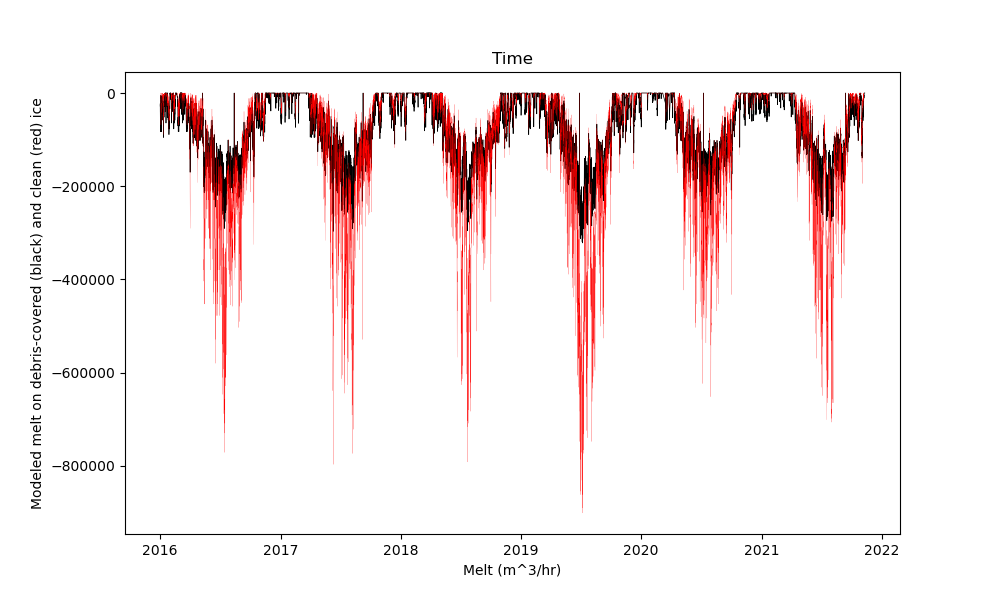

In [25]:
## PLOT MELT RECORD 

%matplotlib widget
fig,ax=plt.subplots(figsize=(10,6))
plt.plot(dates,hrdebrisice,color='black',linewidth=0.5)
plt.plot(dates,hrcleanice,color='red',linewidth=0.1)
plt.xlabel('Melt (m^3/hr)')
plt.ylabel('Modeled melt on debris-covered (black) and clean (red) ice')
plt.title('Time')
plt.show()

In [29]:
## PREP DAILY CAMERON DATA FOR COMPARISON WITH HOURLY DATA 
# 
# # resample at daily interval to save time as a daily value (npsdaily)
npsdaily=nps.resample(rule='24H', offset=0).mean()

# then save new dates vector and temps vector
gatestempsD = npsdaily['GatesNPS'].to_numpy()
datesD = npsdaily.index.to_numpy(dtype='datetime64[ns]')

# Load numpy .txt file debriscummelt_daily.txt
    # set working directory
data_dir = r'~/MLo/KennGlac/data'
# Define relative path to file 
debriscummelt_path = os.path.join(data_dir,
                            "debriscummelt_daily.txt")
debrismeltcum=np.loadtxt(debriscummelt_path)

# debrismeltcum is vector, 2141x0, same shape as gatestempsD. Daily values year-round of cumulative melt values on all debris-covered ice (hrdebrisice_cameron)

# create pandas table "rouncedata" and add debrismeltcum as a column
rouncedata={'debrisice_cameron':debrismeltcum[:]}  # or [:,0]  ??
rouncetable=pd.DataFrame(rouncedata,index=datesD)
rouncetable.index.name = 'DateTime'
# make sure index is format datetime
rouncetable.index = pd.to_datetime(rouncetable.index)

# Select data from 5/1 to 10/31 each year (rouncemeltseason is pd table (1104x1) of daily cum melt values with index DateTime
rouncemeltseason = rouncetable[(rouncetable.index.month > 4) & (rouncetable.index.month <11)]
year=rouncemeltseason.index.year.unique()

OSError: ~/MLo/KennGlac/data/debriscummelt_daily.txt not found.

In [37]:
## SLICE MELT RECORDS INTO 

# Roughly speaking, lowest elevation glacier temps get consistenly postivie in mid-late march and last until end October
# River discharge gets ice-free around end-April and lasts until freeze-up in early November
# So I will be using May 1 - October 31 as the target for these calculations. 

# Make a pandas table (melt) of the melt records to facilitate slicing and summarizing
data={'hrcleanice':hrcleanice,'hrdebrisice':hrdebrisice,'hrcleansnow':hrcleansnow,'hrdebrissnow':hrdebrissnow}
# IF I did the cameron debris-covered thing at hourly timestep (I haven't), then use the row below instead of the one above
# data={'hrcleanice':hrcleanice,'hrdebrisice_constant':hrdebrisice,'hrcleansnow':hrcleansnow,'hrdebrissnow':hrdebrissnow,'hrdebrisice_cameron':debrismeltcum}

print(debrismeltcum.shape)
melt=pd.DataFrame(data,index=dates)
melt.index.name = 'DateTime'
# make sure index is format datetime
melt.index = pd.to_datetime(melt.index)


# Select hourly data from 5/1 to 10/31 each year (I already selecte daily debris cameron data for that time period)
meltseason = melt[(melt.index.month > 4) & (melt.index.month <11)]
year=meltseason.index.year.unique()

# create empty pandas table for results
totalyearlymelt=pd.DataFrame(
    columns=['hrcleanice','hrdebrisice_constant','hrcleansnow','hrdebrissnow','hrdebris_ice_cameron'],
    index=[year])

# Sum data by years (i). This adds in the data from the Cameron calculation
for i in year:
    tempp=meltseason[(meltseason.index.year == i)].sum()
    temppp=-rouncemeltseason[(rouncemeltseason.index.year == i)].sum()
    tempp_concat=np.concatenate((tempp,temppp), axis=0)
    # use .values to get numbers out of weird object
    totalyearlymelt.loc[i,:]=tempp_concat       #.values  

print(totalyearlymelt.head(6))

(2141,)
                hrcleanice hrdebrisice_constant       hrcleansnow  \
DateTime                                                            
2016     -833518950.392633    -555256379.762123 -418022382.696911   
2017     -723886780.374116    -509590856.998642  -363040188.33914   
2018     -736889188.478425    -524213765.083381 -369561093.009634   
2019     -998307812.314839    -595701069.214723 -500666493.751836   
2020     -691347647.547362    -500350667.869364 -346721320.209359   
2021     -701149470.707275    -484329570.574704 -351637083.036527   

              hrdebrissnow hrdebris_ice_cameron  
DateTime                                         
2016     -278469487.426155    -334570203.880341  
2017      -255567535.85841    -305365996.702637  
2018      -262901145.82212    -315135112.036621  
2019     -298753111.984959    -359912834.374023  
2020     -250933441.007212    -301001323.555176  
2021     -242898617.970041    -290771744.160156  


NameError: name 'totalyearlymelt' is not defined

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
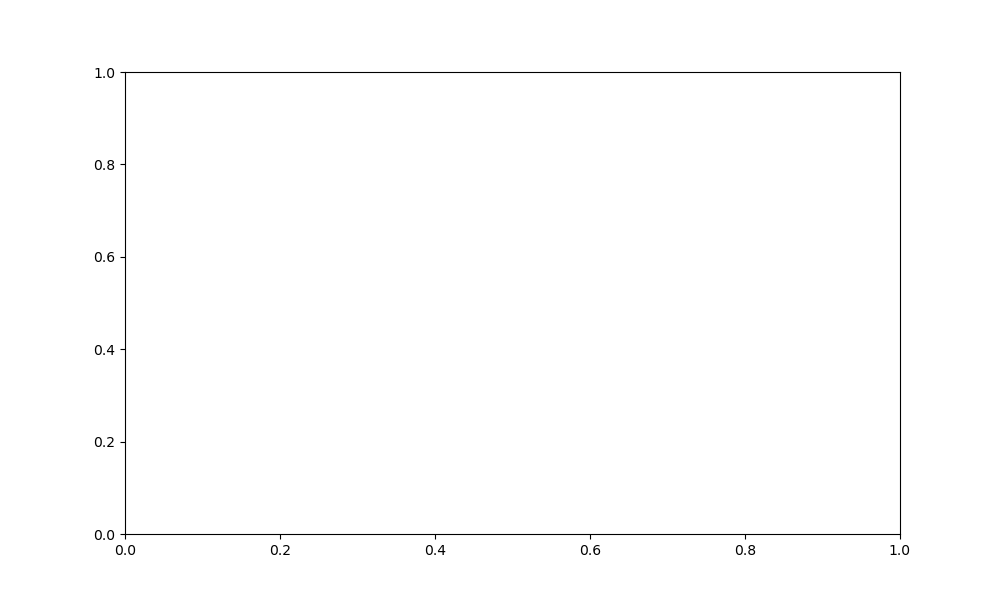

In [27]:
## PLOT ANNUAL RESULTS

# annualQ is from KennRivQ.ipynb, pulled 2021_12_6. This includes only 2017-2021 (no data from 2016)
annualQ = [1328462087.04, 1512917264.74, 1727659577.95, 1348366520.09, 1188672046.56]

# make figure ,presenting melt and discharge as positive numbers
fig,ax=plt.subplots(figsize=(10,6))
plt.plot(year,-totalyearlymelt.hrcleanice,color='red',linewidth=1, label = 'Melt on clean ice')
plt.plot(year,-totalyearlymelt.hrdebrisice_constant,color='black',linewidth=1, label = 'Constant DDF melt on debris-covered ice')
plt.plot(year,-totalyearlymelt.hrdebris_ice_cameron,color='black',linewidth=1,linestyle='dotted', label = 'Variable DDF melt on debris-covered ice')
plt.plot(year,(-totalyearlymelt.hrcleanice - totalyearlymelt.hrdebrisice_constant),color='green',linewidth=2, label = 'Total melt w constant DDF',marker='o')
plt.plot(year,(-totalyearlymelt.hrcleanice - totalyearlymelt.hrdebris_ice_cameron),color='green',linewidth=2, linestyle='dotted', label = 'Total melt w variable DDF',marker='o')
plt.plot(year[1:6],annualQ,color='blue',linewidth=2, label = 'River discharge',marker='o')
plt.xlabel('Year')
plt.ylabel('Melt/discharge (m^3/yr)')
ax.legend(loc='upper left',fontsize=8)
plt.show()

# save as high quality pdf
fig.savefig('temp.pdf',bbox_inches='tight')

annualQ

In [ ]:


# First examine typical "melt season" for low elevation (lowest bin) glacier--we'll call that our river discharge season
fig,ax=plt.subplots(figsize=(10,6))
plt.plot(dates,debristemps[:,0])
plt.plot(dates,debristemps[:,-1],color='red')
ax.grid()
plt.show()

In [ ]:
print(year[1:6])

In [ ]:
totalyearlymelt.iloc[:,1]